In [1]:
# I am not sure I entirely understand the given methods. So in Verma and Lewis method
# we go through every single row and see how a bit flip would affect it.
# But we do not multiply the quadratic coefficients by 2. 
# In examples the quadratic coefficients are always twice smaller in a 
# QUBO row as there will be another instance of the same coefficient, just in a different row.
# So 6x1x6 will be a 3 in row 1 and a 3 in row 6, but when they are added together, they will make a 6.

In [2]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import neal
import greedy
import tabu
import matplotlib.pyplot as plt

import sys
from pathlib import Path
current_path = Path().resolve()
sys.path.append(str(current_path / '../Data/Multidimensional Knapsack'))
from util import *

from IPython.display import display_html
from itertools import chain, cycle

import time
import pickle

# Load data

In [3]:
data_folder = '../data/Multidimensional Knapsack/'
# Weish dataset has smallers problebls, WEING has larger problems.
# We have Weish[01-30] files in Weish folder. Load them.
weish_files_no = 30
weish_file_paths = ['weish//Weish'+ str(i).zfill(2) +'.npz' for i in range(1, weish_files_no + 1)]
weish_loaded_files = [np.load(data_folder + i) for i in weish_file_paths]
# We have WEING[1-8] files in Weing folder. Load them.
weing_files_no = 8
weing_file_paths = ['weing//WEING'+ str(i) +'.npz' for i in range(1, weing_files_no + 1)]
weing_loaded_files = [np.load(data_folder + i) for i in weing_file_paths]
# Merge the datasets and get the needed information.
loaded_files = weish_loaded_files + weing_loaded_files
qubo_sizes = [i['n'] for i in loaded_files]
objectives = [i['objective'] for i in loaded_files]
constraints = [i['constraint'] for i in loaded_files]

# Custom Methods

In [4]:
def convert_1d_qubo_to_2d(qubo, n):
    if (len(qubo)!= (n) * ((n+1) * 0.5)   + 1):
        print('check that n is the correct size')
        return None, None
    constant = qubo[0]
    linear_terms = np.array(qubo[1:(n + 1)])
    no_of_quadratic_terms = len(qubo) - len(linear_terms) -1
    quadratic_terms = np.array(qubo[-no_of_quadratic_terms:])
    k = 0
    qubo_coeffs = []
    for i in range(n):
        coeffs = []
        for j in range(n):
            if(i == j):
                coeffs.append(linear_terms[i])
            elif(j>i):
                coeffs.append(quadratic_terms[k])
                k+=1
            else:
                coeffs.append(0)
        qubo_coeffs.append(coeffs)
    qubo_coeffs = np.array(qubo_coeffs)

    return qubo_coeffs, constant

In [5]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align:left">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [6]:
# TODO add penalty function choosing
def data_prep(qubo_sizes, objectives, constraints, minimization=False):
    # If we are solving maximization problem, we will need to convert it to 
    # minimization by multiplying the objective function by -1
    coef = 1 if minimization else -1
    # Get the unconstrained objective function and the constraint function with constants
    obj_qubos, obj_constants, con_qubos, con_constants = [], [], [], []
    for i in range(len(qubo_sizes)):
        # Unconstrained objective function
        obj = convert_1d_qubo_to_2d(objectives[i], qubo_sizes[i])
        obj_qubos.append(obj[0])
        obj_constants.append(obj[1])
        # Constraint function
        const = convert_1d_qubo_to_2d(constraints[i], qubo_sizes[i])
        con_qubos.append(const[0])
        con_constants.append(const[1])
    # Calculate penalties
    penalties = [util.verma_penalty(i) for i in obj_qubos]
    # QUBO matrix (no constraints)
    Qs = [coef*obj_qubo + penalty * con_qubo for obj_qubo, penalty, con_qubo in zip(obj_qubos, penalties, con_qubos)]
    # Change QUBO matrix to the dwave format
    Qs = [util.convert_QUBO_to_dwave_format(Q) for Q in Qs]
    # Constants
    #cs = [obj_constant+ penalty * con_constant for obj_constant, penalty, con_constant in zip(obj_constants, penalties, con_constants)]
    return Qs, penalties, obj_qubos, obj_constants, con_qubos, con_constants

In [36]:
def run_sampler(Qs, sampler, repeats, **kwargs):
    # Format {seed : [objective_energies, constraint_energies]}
    runs = {}
    # Solve every QUBO n times with a different seed to simulate different runs.
    # Start with 1 as simulated annealing breaks with 0.
    for seed in range(1, repeats + 1):
        clear_output(wait=True)
        # Solve every QUBO
        objs, cons = [], []
        for problem_num in range(len(Qs)):
            response =  sampler.sample_qubo(Qs[problem_num], seed = seed, **kwargs)
            
            # If we want to see more details
            # print("samples=" + str(list(response.samples())))
            # print("energies=" + str(list(response.data_vectors['energy'])) )
            
            # Choose solution with lowest energy
            solution = list(response.lowest())[0]
            y = np.array([int(solution[i]) for i in range(len(solution))])
            
            # Even though we have multiplied the objective function by -1 to 
            # transfer it to minimization problem when defining a QUBO,
            # we do not need to multiply it by -1 again as we are using the original 
            # unmultipled objective function here.
            # So here we will have the original objective function value
            obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
            # The constraint function before multiplying it by penalty coefficient
            con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
            
            objs.append(obj)
            cons.append(con)

        runs[seed] = (objs, cons)
        print(np.round(seed/repeats * 100, 2), '%')
        
    return runs

In [37]:
def record_results(runs, qubo_sizes, penalties, repeats, minimization=False): 
    coef = 1 if minimization else -1
    results = []
    # 1: QUBO size, 2: calculated penalty coefficient, 3: objective function energy 
    # 4: number of broken constraints,
    # 5: total QUBO energy (if transfering maximisation problem to minimisation,
    # we need to take the negative).
    # Total energy should be negative if no constraints were broken.
    for i in range(1, repeats + 1):
        energies = [coef*obj+con*penalty for obj, con, penalty in zip(runs[i][0], runs[i][1], penalties)]
        results.append(pd.DataFrame({'Size' : qubo_sizes, 
                                     'Penalty' : penalties, 
                                     'Objective Function' : runs[i][0], 
                                     'Broken Constraints' : runs[i][1],
                                     'Energy (minimisation)' : energies}))
    return results

In [38]:
# Show  energies/broken constraints/objective function values of all tries in all problems in a single df
def columns_to_table(results, column_name):
    energies = pd.DataFrame()
    repeats = len(results) # Number of repeats is equivalent to the number of results
    for i in range(repeats):
        energies[f'{column_name} {i}'] = results[i][column_name]
    return energies

In [39]:
# Make a table that will display which solution were feasible
def feasibility_table(results):
    feasiblity = pd.DataFrame()
    repeats = len(results) # Number of repeats is equivalent to the number of results
    # Solution is feasibly if no constraints were broken
    for i in range(repeats):
        feasiblity[f'Feasible {i}'] = results[i]['Broken Constraints'] == 0
    return feasiblity

In [40]:
def feasibility_statistic(results):
    # Make tables with energies and feasible results
    feasibility = feasibility_table(results)
    energies = columns_to_table(results, 'Energy (minimisation)')
    # The number of results corresponds to the number of repeats
    repeats = len(results)
    
    # Calculate number of feasible solutions (in all runs)
    stats = pd.DataFrame({'Feasible' : feasibility.sum(axis=1)})
    # Calculate feasibility rate
    stats['Feasibility rate'] = stats['Feasible'] / repeats
    # Calculate mean energy
    stats['Energy mean'] = energies.mean(axis=1)
    # Calculate energy standard deviation
    stats['Energy SD'] = energies.std(axis=1)
    # Calculate total row
    stats.loc['Total'] = stats.sum()
    # Calculate mean row
    stats.loc['Mean'] = stats.mean()
    # Calculate SD row
    stats.loc['SD'] = stats.std()
    
    return stats

# Prepare data

In [41]:
QUBOs, penalties, obj_qubos, obj_constants, con_qubos, con_constants = data_prep(qubo_sizes, objectives, constraints)
repeats = 10

## Greedy

In [43]:
greedy_sampler = greedy.SteepestDescentSampler()
greedy_runs = run_sampler(QUBOs, greedy_sampler, repeats, num_reads=100)

100.0 %


## Simulated Annealing

In [44]:
# Less reads to compensate the run time
sa_sampler = neal.SimulatedAnnealingSampler()
sa_runs = run_sampler(QUBOs, sa_sampler, repeats, num_reads=10)

100.0 %


## Tabu

In [45]:
tabu_sampler = tabu.TabuSampler()
tabu_runs = run_sampler(QUBOs, tabu_sampler, repeats, timeout=20)

100.0 %


## Record the results

In [46]:
greedy_results = record_results(greedy_runs, qubo_sizes, penalties, repeats)
sa_results = record_results(sa_runs, qubo_sizes, penalties, repeats)
tabu_results = record_results(tabu_runs, qubo_sizes, penalties, repeats)
    
# Display the first repetition table
rep = 0
display_side_by_side(greedy_results[rep], sa_results[rep], tabu_results[rep], titles=['Greedy', 'SA', 'Tabu'])

,Size,Penalty,Objective Function,Broken Constraints,Energy (minimisation)
0,85,892,2796,20,15044
1,85,892,1858,6,3494
2,90,892,1409,18,14647
3,85,892,1554,297,263370
4,90,892,2016,12,8688
5,100,892,2794,109,94434
6,100,892,4051,10,4869
7,100,892,2416,50,42184
8,100,892,1167,74,64841
9,110,892,2582,85,73238


## Analyse results

In [47]:
# Show total energies of all tries in all problems in a single df
energies_greedy = columns_to_table(greedy_results, 'Energy (minimisation)')
energies_sa = columns_to_table(sa_results, 'Energy (minimisation)')
energies_tabu = columns_to_table(tabu_results, 'Energy (minimisation)')

energies_tabu

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,21317,99690,106487,77006,6943,40304,235810,52078,49667,18040
1,191053,1422,176593,47020,4737,116366,391276,71278,3031,131446
2,180275,805724,12264,12666,212885,6824,3343,84285,648,465219
3,18061,438724,255,659146,256240,798340,74362,100926,290499,552692
4,42633,201948,90216,148735,91587,34009,20089,651881,6918,601061
5,543,379592,334750,403480,288106,216670,113884,749136,324358,50450
6,12985,12985,1415,12985,-721,57687,39745,12985,54017,682136
7,235105,-321,43665,91646,175346,914795,1648783,241563,485556,605773
8,430380,120749,1654,4318,6930,64,43588,129888,6455,6481
9,28962,303671,59402,1448869,-1464,22046,801698,12218,6653,4511


In [48]:
# Show number of broken constraints of all tries in all problems in a single df
broken_constraints_greedy = columns_to_table(greedy_results, 'Broken Constraints')
broken_constraints_sa = columns_to_table(sa_results, 'Broken Constraints')
broken_constraints_tabu = columns_to_table(tabu_results, 'Broken Constraints')

broken_constraints_greedy

,Broken Constraints 0,Broken Constraints 1,Broken Constraints 2,Broken Constraints 3,Broken Constraints 4,Broken Constraints 5,Broken Constraints 6,Broken Constraints 7,Broken Constraints 8,Broken Constraints 9
0,20,12,52,6,26,72,61,4,51,6
1,6,53,17,12,14,11,4,33,21,6
2,18,1,61,162,52,60,35,16,62,114
3,297,39,115,189,173,50,74,15,40,238
4,12,33,94,347,159,241,85,30,93,45
5,109,82,54,1,23,31,9,9,18,5
6,10,17,17,0,13,5,5,14,24,63
7,50,2,2,12,1,44,2,70,5,5
8,74,230,148,72,237,116,10,140,254,73
9,85,207,115,94,145,117,397,161,230,6


In [49]:
# Show feasible solutions
feasible_full_greedy = feasibility_table(greedy_results)
feasible_full_sa = feasibility_table(sa_results)
feasible_full_tabu = feasibility_table(tabu_results)

feasible_full_tabu

,Feasible 0,Feasible 1,Feasible 2,Feasible 3,Feasible 4,Feasible 5,Feasible 6,Feasible 7,Feasible 8,Feasible 9
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False


In [50]:
# Calculate number of feasible solutions with mean and SD (in all runs)
feasible_greedy = feasibility_statistic(greedy_results)
feasible_sa = feasibility_statistic(sa_results)
feasible_tabu = feasibility_statistic(tabu_results)

# Display the table
display_side_by_side(feasible_greedy, feasible_sa, feasible_tabu, titles=['Greedy', 'SA', 'Tabu'])

,Feasible,Feasibility rate,Energy mean,Energy SD
0,0.000000,0.000000,2.523400e+04,2.298378e+04
1,0.000000,0.000000,1.365690e+04,1.364732e+04
2,0.000000,0.000000,4.950270e+04,4.318905e+04
3,0.000000,0.000000,1.075230e+05,8.619241e+04
4,0.000000,0.000000,9.937200e+04,9.511356e+04
5,0.000000,0.000000,2.809500e+04,3.229012e+04
6,1.000000,0.100000,1.222470e+04,1.609175e+04
7,0.000000,0.000000,1.468620e+04,2.236120e+04
8,0.000000,0.000000,1.183641e+05,7.307730e+04
9,0.000000,0.000000,1.355338e+05,9.441894e+04


# Greedy Algorithm Run Length Distribution

In [207]:
from scipy.interpolate import make_interp_spline, BSpline
import math

In [357]:
# Solve QUBO a lot of times
problem_num = 25
seed = 0
repeats = 10000
sampler = greedy.SteepestDescentSampler()
response =  sampler.sample_qubo(QUBOs[problem_num], seed=seed, num_reads=repeats)

In [358]:
steps = []
energies = []

for step, energy in response.data(fields=['num_steps', 'energy'], sorted_by='num_steps'):
    steps.append(step)
    energies.append(energy)

# Sort both lists by the number of steps 
steps, eneriges = (list(elements) for elements in zip(*sorted(zip(steps, energies))))
# Our target is the mean energy 
target = (sum(eneriges)/len(eneriges))
# Find runs that got energy above our target
successful = [i < target for i in energies]
# Make a dataframe
rld = pd.DataFrame({'Steps' : steps, 'Successful' : successful})
# Sum successful runs by repeating steps
rld = rld.groupby(by=['Steps'], axis=0).sum()
# Calculate cumulative number of successful runs
rld['Cumulative'] = rld['Successful'].cumsum()
# Calculate cumulative percentage of successful runs
rld['Cumulative Percentage'] = rld['Cumulative']/max(rld['Cumulative']) * 100
rld

,Successful,Cumulative,Cumulative Percentage
Steps,,,
13,6,6,0.069881
14,9,15,0.174703
15,27,42,0.489168
16,57,99,1.153040
17,87,186,2.166317
...,...,...,...
76,0,8586,100.000000
77,0,8586,100.000000
78,0,8586,100.000000


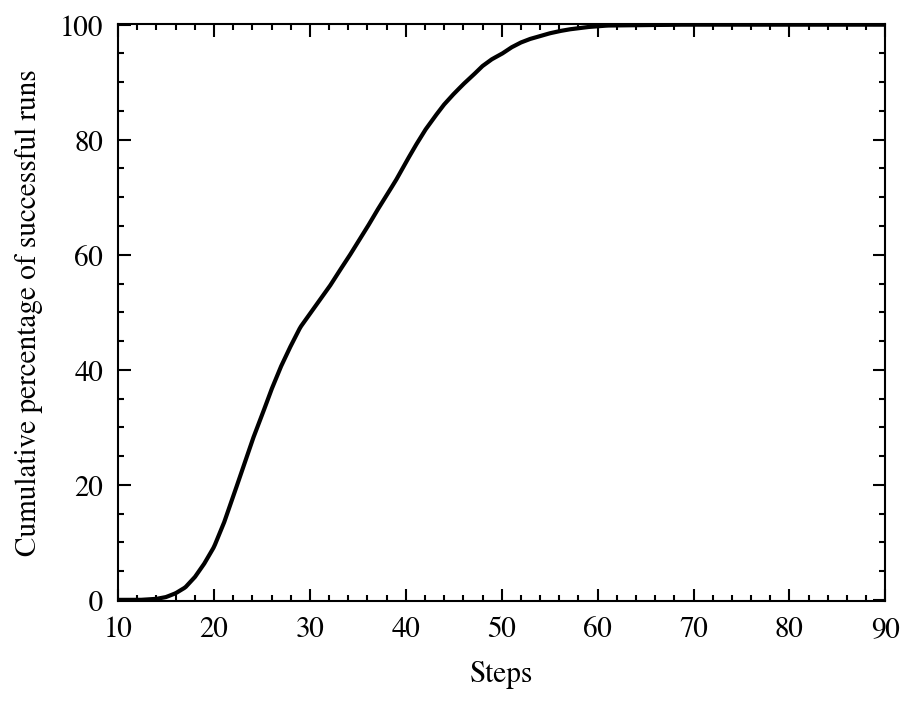

In [370]:
# Set plot styles
plt.style.use(['science', 'no-latex', 'ieee'])
# Set limits 
# x-axis limits are floor and ceiling to nearest 10 of max and min values
lowest_steps = math.floor(rld.index[0]/10)*10
highest_steps = math.ceil(rld.index[-1]/10)*10
offset = 0.2 # Offset is needed to see the line at graph borders
plt.axis((lowest_steps, highest_steps, 0-offset, 100+offset))
# Set labels and dpi
plt.xlabel("Steps")
plt.ylabel("Cumulative percentage of successful runs")
plt.gcf().set_dpi(300) 
# Smooth the line, otherwise it will look like a staircase
steps_new = np.linspace(lowest_steps, highest_steps, 500) # Create more points for x-axis
spl = make_interp_spline(rld.index, rld['Cumulative Percentage'], k=1) 
smooth_percentage = spl(steps_new)
# Limit smoothed values to 0-100 too
smooth_percentage = [0 if i < 0 else i for i in smooth_percentage]
smooth_percentage = [100 if i > 100 else i for i in smooth_percentage]
# Make a plot
plt.plot(steps_new, smooth_percentage)

# Tabu Search Run Time Distribution

In [371]:
times = []
energies = []
sampler = tabu.TabuSampler()
repeats = 10000
# Hyperparameters
timeout = 10 # default 20
problem_num = 25

# num_restarts has to be 1 (Towards a Characterisation of the Behaviour of Stochastic Local Search Algorithms for SAT)
for seed in range(1, repeats):
    # Record start time
    start = time.time()
    # Run algorithms
    response =  sampler.sample_qubo(QUBOs[problem_num], seed=seed, timeout=timeout, num_reads=1, num_restarts=1)
    # Record end time and find the difference, which is equivalent to run time
    end = time.time()
    times.append(end - start)
    data = response.data(fields=['energy'])
    energy = next(data).energy
    energies.append(energy)

In [372]:
# Sort both lists by the number of steps 
times, eneriges = (list(elements) for elements in zip(*sorted(zip(times, energies))))
# Our target is the mean energy 
target = (sum(eneriges)/len(eneriges))
# Find runs that got energy above our target
successful = [i < target for i in energies]
# Make a dataframe
rtd = pd.DataFrame({'Time' : times, 'Successful' : successful})
# Sum successful runs by repeating steps
rtd = rtd.groupby(by=['Time'], axis=0).sum()
# Calculate cumulative number of successful runs
rtd['Cumulative'] = rtd['Successful'].cumsum()
# Calculate cumulative percentage of successful runs
rtd['Cumulative Percentage'] = rtd['Cumulative']/max(rtd['Cumulative']) * 100
rtd

,Successful,Cumulative,Cumulative Percentage
Time,,,
0.014980,0,0,0.000000
0.015094,1,1,0.011916
0.015118,1,2,0.023832
0.015146,1,3,0.035748
0.015167,0,3,0.035748
...,...,...,...
0.029834,1,8389,99.964252
0.030241,0,8389,99.964252
0.030250,1,8390,99.976168


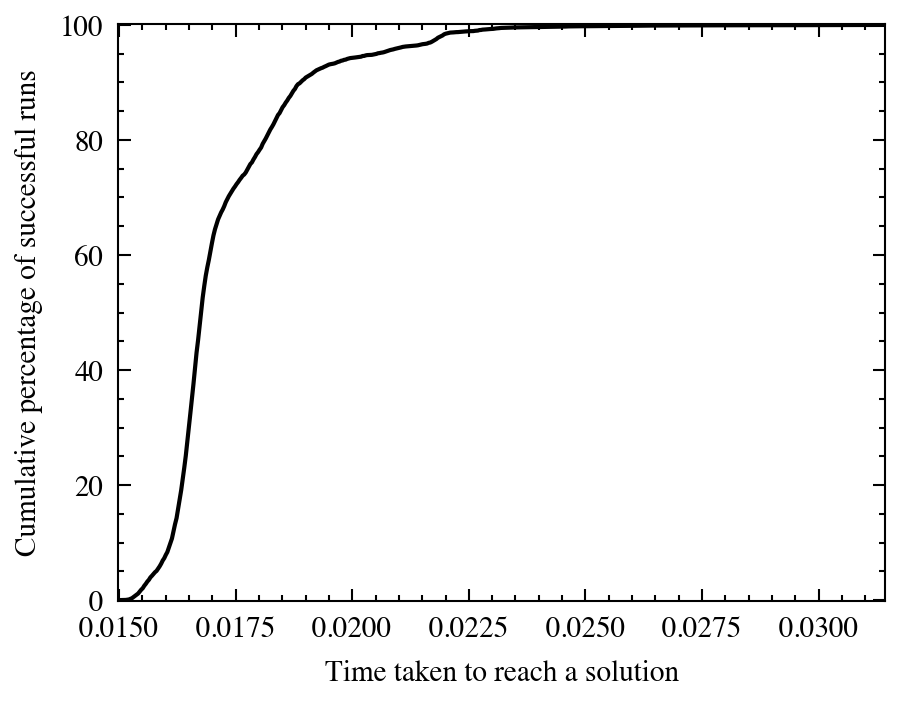

In [373]:
# Set plot styles
plt.style.use(['science', 'no-latex', 'ieee'])
# Set limits 
lowest_steps = rtd.index[0]
highest_steps = rtd.index[-1]
offset = 0.2 # Offset is needed to see the line at graph borders
plt.axis((lowest_steps, highest_steps, 0-offset, 100+offset))
# Set labels and dpi
plt.xlabel("Time taken to reach a solution (s)")
plt.ylabel("Cumulative percentage of successful runs")
plt.gcf().set_dpi(300) 
# Smooth the line, otherwise it will look like a staircase
times_new = np.linspace(rtd.index[0], rtd.index[-1], 500) # Create more points for x-axis
spl = make_interp_spline(rtd.index, rtd['Cumulative Percentage'], k=1) 
smooth_percentage = spl(times_new)
# Limit smoothed values to 0-100 too
smooth_percentage = [0 if i < 0 else i for i in smooth_percentage]
smooth_percentage = [100 if i > 100 else i for i in smooth_percentage]
# Make a plot
plt.plot(times_new, smooth_percentage)

# Save results

In [40]:
data_folder = '../Data/Produced/'
broken_constraints_greedy.to_pickle(data_folder + 'monotone_greedy_broken_constraints.pkl')
broken_constraints_sa.to_pickle(data_folder + 'monotone_sa_broken_constraints.pkl')
broken_constraints_tabu.to_pickle(data_folder + 'monotone_tabu_broken_constraints.pkl')

# Statistical significance

In [64]:
new_energies_sa = energies_sa

In [56]:
old_energies_sa = energies_sa

In [73]:
new_energies_sa

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,-902.131051,-2141.590319,-836.791027,-1068.257379,-1763.874852,-1475.377804,-2112.100354,-1874.971665,-1281.590319,-2218.397875
1,4730.862069,6060.804598,10192.367816,12637.517241,11076.678161,20567.862069,8396.643678,6560.149425,6507.333333,1848.620690
2,-3217.507014,-2810.909419,-2584.046493,-2754.056112,-988.062926,-2875.351102,-2457.103407,-1848.045691,-2413.351904,-2306.849699
3,-1130.404022,-777.937843,-1236.188300,-1358.720293,-641.279707,-738.703839,-1378.826325,-930.756856,-673.583181,206.925046
4,-2409.998012,-3166.764215,-2964.873161,-1693.217893,-3317.784891,-2295.336382,-2389.109344,-2490.290258,-2623.191650,-2377.018688
5,-3295.432277,-3832.820749,-2412.000000,-3020.600000,-3442.288184,-2752.375793,-1849.429395,-3060.842075,-3336.577522,-3288.933141
6,-2111.843068,-2157.328024,-3109.797050,-860.437758,-2794.000000,-2546.764602,-2600.558112,-3585.919764,-3072.844838,-1968.474926
7,-2943.143953,-3766.274336,-3971.374631,-3570.353982,-3190.282596,-1675.234218,-2947.894985,-3378.329204,-3094.434218,-2687.184071
8,-2907.792325,-3346.986907,-2091.544470,-2853.242889,-3289.448758,-2376.260045,-3725.064560,-2736.237923,980.685327,-2590.589165
9,-3038.496804,-3362.469406,-3165.136986,6979.304110,3475.221005,21242.445662,-3942.113242,-3099.084932,-3322.638356,-3168.582648


In [72]:
old_energies_sa

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,1064359,930121,1282321,1342006,1745001,1872304,401959,1513352,748674,1228315
1,809123,636792,670356,1078623,550992,613876,934243,2071094,771698,979706
2,777682,814551,1157031,834678,1450204,536447,1649108,1695865,1298578,1459087
3,1269897,2492120,1262772,1655733,1025376,1642915,884698,835206,1614714,1366486
4,1201929,967255,2780615,1811292,1851426,1295248,989566,988282,1712814,1254057
5,1610191,1322709,805087,1236329,1448591,596297,1251753,1156860,736642,1006118
6,1697585,1223121,1780338,965930,861754,1215579,665063,1191297,1122931,599638
7,1052120,1175272,947556,891776,667456,1108824,899728,1240618,855547,1200478
8,2044134,1259946,1285652,786684,1168741,1191944,1949622,1748498,1156574,1081028
9,1010243,1992693,1535954,1428919,1372386,1351293,1565095,1721470,1564152,1339040


In [65]:
import scipy.stats as stats

In [69]:
new_energies_sa.iloc[0]

Energy (minimisation) 0    -902.131051
Energy (minimisation) 1   -2141.590319
Energy (minimisation) 2    -836.791027
Energy (minimisation) 3   -1068.257379
Energy (minimisation) 4   -1763.874852
Energy (minimisation) 5   -1475.377804
Energy (minimisation) 6   -2112.100354
Energy (minimisation) 7   -1874.971665
Energy (minimisation) 8   -1281.590319
Energy (minimisation) 9   -2218.397875
Name: 0, dtype: float64

In [71]:
old_energies_sa.iloc[0]

Energy (minimisation) 0    1064359
Energy (minimisation) 1     930121
Energy (minimisation) 2    1282321
Energy (minimisation) 3    1342006
Energy (minimisation) 4    1745001
Energy (minimisation) 5    1872304
Energy (minimisation) 6     401959
Energy (minimisation) 7    1513352
Energy (minimisation) 8     748674
Energy (minimisation) 9    1228315
Name: 0, dtype: int64

In [70]:
stats.ttest_ind(new_energies_sa.iloc[0], old_energies_sa.iloc[0])

Ttest_indResult(statistic=-8.575018150805937, pvalue=8.994725044770677e-08)

# new

In [153]:
def verma_penalty(qubo_obj):
        weights = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        for i in range(len(qubo_obj)):
            weights[k]= qubo_obj[i][i]
            weights[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights[k]+= qubo_obj[i][j]
                    else:
                        weights[k+1]-=qubo_obj[i][j]
            k = k+2
        return min(weights)

In [32]:
def new_penalty(qubo_obj, con_obj):
        weights_obj = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(qubo_obj)):
            weights_obj[k]= qubo_obj[i][i]
            weights_obj[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights_obj[k]+= qubo_obj[i][j]
                    else:
                        weights_obj[k+1]-=qubo_obj[i][j]
            k = k+2
            
        weights_con = np.zeros(shape = (len(con_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(con_obj)):
            weights_con[k]= con_obj[i][i]
            weights_con[k+1]= -con_obj[i][i]
            for j in range(len(con_obj)):
                if(i!=j):
                    if(con_obj[i][j] > 0):
                        weights_con[k]+= con_obj[i][j]
                    else:
                        weights_con[k+1]-=con_obj[i][j]
            k = k+2
        
        return max(weights_obj)/min(weights_con[weights_con > 0])